## Introduccion

Realizaremos un análisis exploratorio de los datos de la compañía Interconnect. El propósito de la empresa es poder pronosticar la tasa de cancelación de clientes.

#### Plan

1. Preparación del Ambiente
- Cargar y verificar la integridad de los datos.
- Realizar las conversiones necesarias en los tipos de datos.
- Unir los conjuntos de datos en un único DataFrame.

2. Análisis Exploratorio de Datos (EDA)
- Describir las estadísticas generales de los datos.
- Visualizar distribuciones de variables importantes (e.g., MonthlyCharges, TotalCharges, SeniorCitizen).
- Explorar correlaciones entre variables mediante mapas de calor.
- Realizar análisis de contingencia para evaluar relaciones significativas (e.g., entre MonthlyCharges y StreamingTV).

3. Preparación de los Datos para el Modelado
- Crear nuevas características (e.g., ContractDuration, ActiveContract).
- Convertir variables categóricas a variables numéricas (codificación binaria).
- Manejar valores nulos (NaN), especialmente en TotalCharges y otras columnas relevantes.

4. Dividir los Datos en Conjuntos de Entrenamiento y Prueba
- Realizar la división de los datos en conjuntos de entrenamiento y prueba con una proporción adecuada (e.g., 80% entrenamiento, 20% prueba).

5. Desarrollo del Modelo
- Seleccionar y entrenar varios modelos de clasificación (e.g., regresión logística, árboles de decisión, Random Forest, XGBoost).
- Evaluar el desempeño de cada modelo utilizando la métrica AUC-ROC y exactitud.

6. Evaluación y Selección del Modelo
- Comparar los modelos basados en AUC-ROC y seleccionar el mejor modelo.
- Realizar validación cruzada para garantizar la robustez del modelo seleccionado.

7. Preparar el Informe
- Documentar todo el proceso, desde el EDA hasta la selección del modelo.
- Incluir visualizaciones y explicaciones claras de los resultados obtenidos.
- Proporcionar recomendaciones basadas en los hallazgos del análisis y modelado.

Primeramente, observamos la relación - entidad entre los conjuntos de datos: 'customerID' es el atributo que estos comparten, por lo que es lo que los relaciona de la siguiente manera:

1. Un cliente puede tener un contrato.
2. Un contrato está asociado a un cliente.
3. Un cliente puede tener varios servicios de internet.
4. Un cliente puede tener varios servicios telefónicos.

Esto se traduce a:

- El conjunto 'client' tiene una relación de uno a uno con el conjunto 'contract'.
- El conjunto 'client' tiene una relación de uno a muchos con el conjunto 'internet'.
- El conjunto 'client' tiene una relación de uno a muchos con el conjunto 'phone'.

## Inicialización

Importamos las librerias necesarias para ralizar el trabajo.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings

from scipy.stats import chi2_contingency

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, KFold, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from xgboost import XGBClassifier

from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from keras.callbacks import EarlyStopping
import tensorflow as tf

from imblearn.over_sampling import SMOTE

Inicialización de variables globales

In [35]:
random_state = np.random.RandomState(417)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

## EDA

Comenzamos con el análisis exploratorio de los datos; primero cargamos los conjuntos y echamos un vistazo a estos.

In [3]:
contract_df = pd.read_csv('final_provider\\final_provider\\contract.csv')
personal_df = pd.read_csv('final_provider\\final_provider\\personal.csv')
internet_df = pd.read_csv('final_provider\\final_provider\\internet.csv')
phone_df = pd.read_csv('final_provider\\final_provider\\phone.csv')

In [4]:
contract_df.sample(n=5, random_state=117)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
6921,5243-SAOTC,2015-08-01,No,Month-to-month,Yes,Bank transfer (automatic),79.85,4308.25
6802,5626-MGTUK,2018-06-01,No,Month-to-month,Yes,Bank transfer (automatic),89.10,1879.25
1913,7188-CBBBA,2014-09-01,No,One year,Yes,Electronic check,95.50,6153.85
4201,1166-PQLGG,2014-02-01,No,Two year,No,Bank transfer (automatic),19.55,1463.45
3857,3675-EQOZA,2019-09-01,No,Month-to-month,No,Bank transfer (automatic),20.65,93.55


La información de los contratos con fechas anteriores al 1 de febrero de 2020 no es válida. Podemos ver aquellos contratos que ya están terminados (y su fecha de terminación) y los que aún no. Esto es importante para el tipo de predicción que la compañía desea hacer. También podemos observar los tipos de contratos (períodos), si reciben la factura por papel o no, el método de pago, los cargos mensuales y los cargos totales (por si el cliente tiene más de un contrato).

In [5]:
personal_df.sample(n=5, random_state=117)

,customerID,gender,SeniorCitizen,Partner,Dependents
6921,5243-SAOTC,Male,0,No,No
6802,5626-MGTUK,Female,0,No,No
1913,7188-CBBBA,Female,0,No,No
4201,1166-PQLGG,Female,0,Yes,Yes
3857,3675-EQOZA,Male,0,No,No


Informacion general del cliente, como su genero, si es una persona de la tercera edad, si esta casado y si tiene dependientes.

In [6]:
internet_df.sample(n=5, random_state=117)

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
1809,4706-DGAHW,DSL,No,No,No,No,No,No
4752,4024-CSNBY,Fiber optic,Yes,Yes,Yes,Yes,No,No
3196,5606-AMZBO,Fiber optic,Yes,No,No,No,No,No
5428,2314-TNDJQ,DSL,Yes,Yes,Yes,Yes,No,Yes
770,5651-YLPRD,Fiber optic,No,Yes,No,No,Yes,No


Si el cliente tiene mas de un servicio de internet lo podemos ver aqui, igual el tipo de servicio general.

In [8]:
phone_df.sample(n=5, random_state=117)

,customerID,MultipleLines
5519,8775-LHDJH,Yes
2499,5074-FBGHB,Yes
1560,6303-KFWSL,Yes
5647,6394-HHHZM,No
5961,3118-UHVVQ,Yes


Aqui simplemente confirmamos si el cliente tiene tiene múltiples líneas telefónicas.

Pasamos a revisar la informacion de cada dataframe.

In [9]:
contract_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


Las columnas 'BeginDate', 'EndDate' y 'TotalCharges' tienen el tipo de dato equivocado. Vamos a manejarlas:

In [10]:
contract_df['BeginDate'] = pd.to_datetime(contract_df['BeginDate'])
contract_df['EndDate'] = contract_df['EndDate'].replace('No', pd.NaT)
contract_df['EndDate'] = pd.to_datetime(contract_df['EndDate'])
contract_df['TotalCharges'] = pd.to_numeric(contract_df['TotalCharges'], errors='coerce')
valores_problematicos = contract_df[contract_df['TotalCharges'].isna()]
valores_problematicos.size

88

In [11]:
reference_date = pd.to_datetime('2020-02-01')
m = contract_df[contract_df['BeginDate'] >= reference_date]
print(m.size)
m

88


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
488,4472-LVYGI,2020-02-01,NaT,Two year,Yes,Bank transfer (automatic),52.55,NaN
753,3115-CZMZD,2020-02-01,NaT,Two year,No,Mailed check,20.25,NaN
936,5709-LVOEQ,2020-02-01,NaT,Two year,No,Mailed check,80.85,NaN
1082,4367-NUYAO,2020-02-01,NaT,Two year,No,Mailed check,25.75,NaN
1340,1371-DWPAZ,2020-02-01,NaT,Two year,No,Credit card (automatic),56.05,NaN
3331,7644-OMVMY,2020-02-01,NaT,Two year,No,Mailed check,19.85,NaN
3826,3213-VVOLG,2020-02-01,NaT,Two year,No,Mailed check,25.35,NaN
4380,2520-SGTTA,2020-02-01,NaT,Two year,No,Mailed check,20.00,NaN
5218,2923-ARZLG,2020-02-01,NaT,One year,Yes,Mailed check,19.70,NaN
6670,4075-WKNIU,2020-02-01,NaT,Two year,No,Mailed check,73.35,NaN


In [12]:
valores_problematicos

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
488,4472-LVYGI,2020-02-01,NaT,Two year,Yes,Bank transfer (automatic),52.55,NaN
753,3115-CZMZD,2020-02-01,NaT,Two year,No,Mailed check,20.25,NaN
936,5709-LVOEQ,2020-02-01,NaT,Two year,No,Mailed check,80.85,NaN
1082,4367-NUYAO,2020-02-01,NaT,Two year,No,Mailed check,25.75,NaN
1340,1371-DWPAZ,2020-02-01,NaT,Two year,No,Credit card (automatic),56.05,NaN
3331,7644-OMVMY,2020-02-01,NaT,Two year,No,Mailed check,19.85,NaN
3826,3213-VVOLG,2020-02-01,NaT,Two year,No,Mailed check,25.35,NaN
4380,2520-SGTTA,2020-02-01,NaT,Two year,No,Mailed check,20.00,NaN
5218,2923-ARZLG,2020-02-01,NaT,One year,Yes,Mailed check,19.70,NaN
6670,4075-WKNIU,2020-02-01,NaT,Two year,No,Mailed check,73.35,NaN


Los valores 'No' en 'EndDate' se sustituyeron por 'NaT' (not a time).

Nos encontramos con que muchos de los valores en 'TotalCharges' están vacíos (NaN); los cambiaremos a 0.

Los mismo datos que son a partir de 02/01/2020 son los que les falta los cargos totales.

In [13]:
contract_df['TotalCharges'] = contract_df['TotalCharges'].fillna(0).astype(float)

In [14]:
personal_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


Los tipos de datos son correctos, no hay valores nulos.

In [15]:
internet_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


Los tipos de datos son correctos, no hay valores nulos.

In [16]:
phone_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


Los tipos de datos son correctos, no hay valores nulos.

Después pasamos a tener una descripción estadística de algunos datos, como los gastos mensuales y totales por cliente, el servicio de internet más popular, si la mayoría o minoría de los clientes es mayor de edad o están casados, o si la mayoría de estos tiene múltiples líneas o no.

In [17]:
print(contract_df[['MonthlyCharges','TotalCharges']].describe())
print()
print(personal_df.describe())
print()
print(internet_df['InternetService'].describe())
print()
print(phone_df['MultipleLines'].describe())

       MonthlyCharges  TotalCharges
count     7043.000000   7043.000000
mean        64.761692   2279.734304
std         30.090047   2266.794470
min         18.250000      0.000000
25%         35.500000    398.550000
50%         70.350000   1394.550000
75%         89.850000   3786.600000
max        118.750000   8684.800000

       SeniorCitizen
count    7043.000000
mean        0.162147
std         0.368612
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000

count            5517
unique              2
top       Fiber optic
freq             3096
Name: InternetService, dtype: object

count     6361
unique       2
top         No
freq      3390
Name: MultipleLines, dtype: object


Nos damos una idea de la variabilidad en los datos, como que hubo clientes que nomás estuvieron un mes (cargo total igual al cargo mensual). Vemos que la mayoría de la gente paga entre 70 y 90 dólares al mes. La mayoría de los clientes no son de la tercera edad. La mayoría de los clientes prefiere fibra óptica o que también solo cuentan con una línea telefónica.

### Distribuciones

Definimos una función que nos ayudará a graficar.

In [18]:
def distribution_plot(df, column):
    sns.set_theme(style="whitegrid")
    plt.figure(figsize=(9, 4))

    if column in ('InternetService', 'MultipleLines'):
        sns.countplot(x=column, data=df)
    else:
        sns.histplot(df[column], kde=True)
    
    plt.title(f'Distribución de {column}')
    plt.xlabel(column)
    plt.ylabel('Frecuencia')
    plt.tight_layout()
    plt.show()

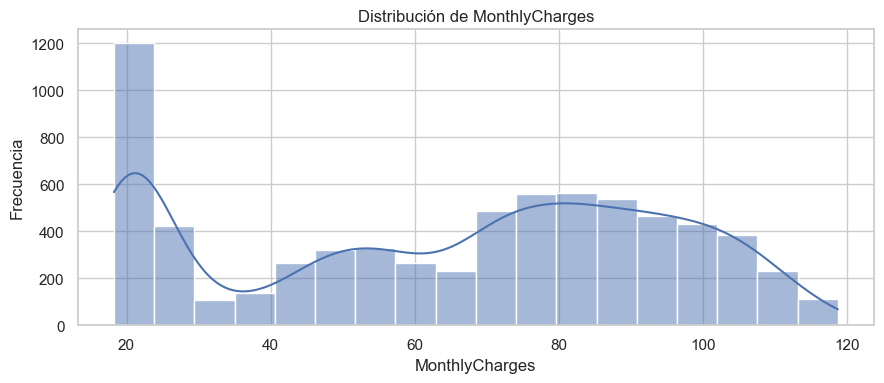

In [19]:
distribution_plot(contract_df, 'MonthlyCharges')

La distribución de gastos mensuales es uniforme y con un pico al inicio; la mayoría de los usuarios solo pagan el plan mínimo.

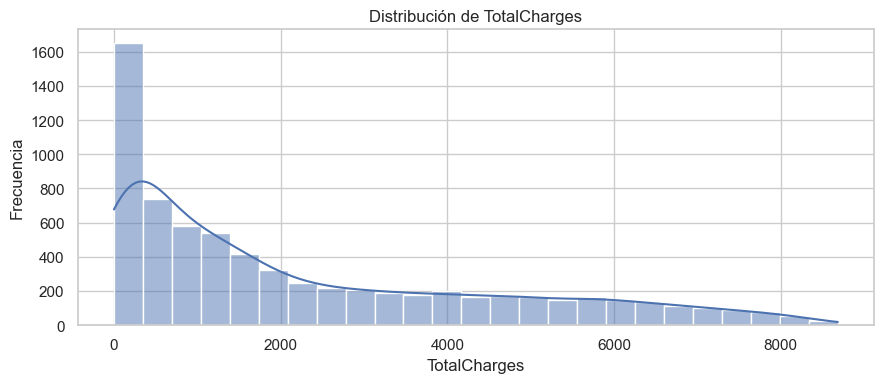

In [20]:
distribution_plot(contract_df, 'TotalCharges')

Un pico al inicio del gráfico en los gastos totales por cliente podría indicar que muchos de estos solo prueban el servicio por un par de meses antes de darse de baja. También puede indicar que hay muchos usuarios nuevos al momento de recolectar esta información.

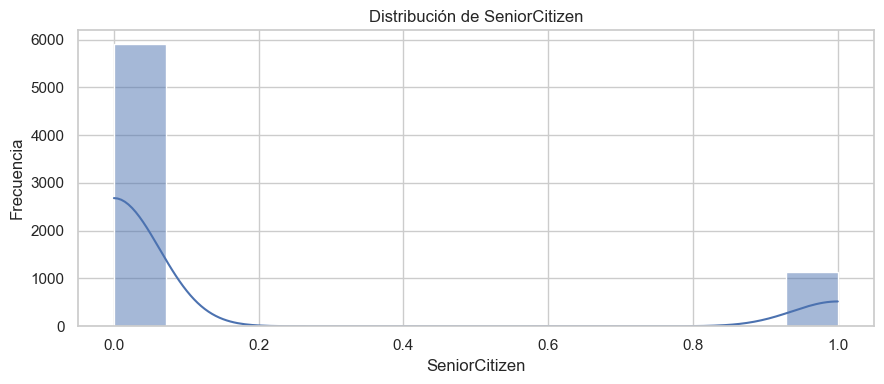

In [21]:
distribution_plot(personal_df, 'SeniorCitizen')

Una diferencia de casi x6 en las diferencias de edades, tal vez sea momento de hacer promociones entre personas de la tercera edad.

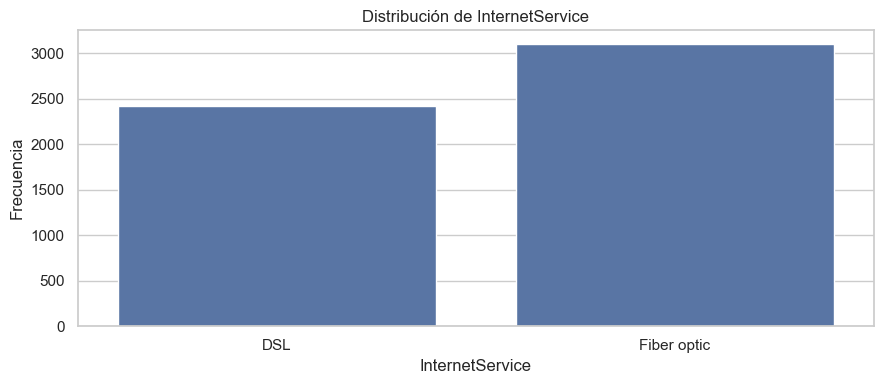

In [22]:
distribution_plot(internet_df, 'InternetService')

La preferencia en tipos de servicio de internet es poca, siendo la fibra óptica la favorita.

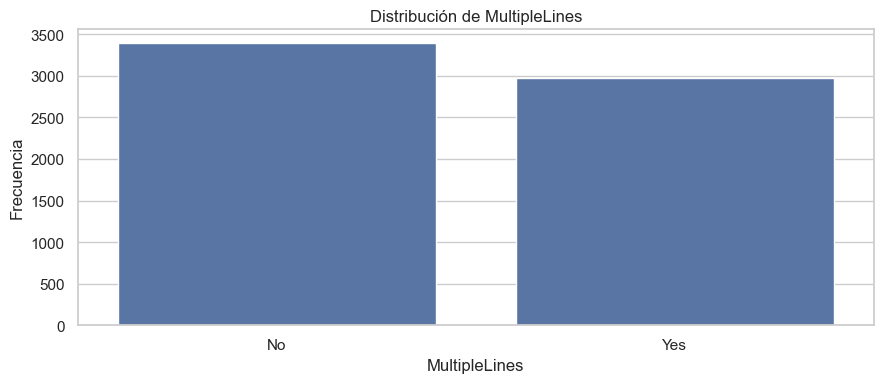

In [23]:
distribution_plot(phone_df, 'MultipleLines')

Aquí la diferencia es menor a la comparación anterior; el número de clientes con múltiples líneas telefónicas es casi igual al de los que no. ¿Tal vez podríamos motivar a los clientes que no tienen múltiples líneas a que contraten otra línea?

### Relaciones entre tablas

Investiguemos las relaciones entre los datos de distintos conjuntos usando la clave 'customerID'. Primero, crearemos un único dataframe.

In [24]:
merged_df = contract_df.merge(personal_df, on='customerID', how='left') \
                       .merge(internet_df, on='customerID', how='left') \
                       .merge(phone_df, on='customerID', how='left')

merged_df.sample(n=10, random_state=random_state)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
6139,3039-MJSLN,2019-11-01,NaT,Month-to-month,No,Bank transfer (automatic),20.20,50.60,Male,0,No,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
1208,5494-HECPR,2019-10-01,2019-11-01,Month-to-month,Yes,Electronic check,80.25,80.25,Female,0,No,No,Fiber optic,No,No,No,No,Yes,No,No
1606,6374-NTQLP,2014-02-01,NaT,Two year,Yes,Credit card (automatic),104.10,7447.70,Male,1,Yes,Yes,Fiber optic,Yes,No,Yes,Yes,Yes,Yes,No
2949,3489-VSFRD,2015-06-01,NaT,One year,Yes,Credit card (automatic),60.25,3282.75,Female,0,No,No,DSL,Yes,No,Yes,Yes,No,No,No
2980,5598-IKHQQ,2014-02-01,NaT,Two year,No,Credit card (automatic),25.45,1866.45,Female,0,No,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes
3725,0968-GSIKN,2019-10-01,2019-11-01,Month-to-month,Yes,Mailed check,70.80,70.80,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No
7024,7398-LXGYX,2016-06-01,NaT,Month-to-month,Yes,Credit card (automatic),84.80,3626.35,Male,0,Yes,No,Fiber optic,Yes,No,Yes,No,No,No,Yes
3367,7109-CQYUZ,2015-10-01,NaT,Two year,Yes,Mailed check,89.25,4652.40,Male,0,No,No,DSL,Yes,Yes,Yes,Yes,Yes,Yes,Yes
3674,7825-GKXMW,2019-12-01,2020-01-01,Month-to-month,No,Electronic check,45.80,45.80,Female,0,No,No,DSL,No,No,No,No,No,No,No
574,6030-REHUX,2017-10-01,NaT,Month-to-month,Yes,Electronic check,110.85,3204.40,Female,1,Yes,No,Fiber optic,No,Yes,Yes,Yes,Yes,Yes,Yes


Convertimos todos los valores NaN a la cadena 'No' en aquellas entradas donde el cliente no tiene múltiples líneas y no tienen servicio de internet.

In [25]:
merged_df.fillna('No', inplace=True)

# Realizamos la conversion de nuevo ya que la operacion anterior convierte el tipo de datos de la columna a object
merged_df['EndDate'] = merged_df['EndDate'].replace('No', pd.NaT)
merged_df['EndDate'] = pd.to_datetime(merged_df['EndDate'])

##### Análisis de Correlación

Realicemos un análisis de correlación con el dataframe combinado.

Primero codificaremos las características categóricas para poder crear una matriz de correlación. Agregaremos una nueva columna que cuenta el número de días de duración del contrato del cliente, así podremos relacionar la duración del contrato con las demás variables. Después, realizaremos una codificación binaria a la columna 'EndDate', en donde 1 será que el contrato sigue activo y 0 si finalizó. Así podremos obtener más información.

In [26]:
merged_df_encoded = merged_df.copy()
merged_df_encoded['ActiveContract'] = merged_df_encoded['EndDate'].isna().astype(int)
merged_df_encoded['ContractDuration'] = (merged_df_encoded['EndDate'] - merged_df_encoded['BeginDate']).dt.days
merged_df_encoded['ContractDuration'].fillna(-1, inplace=True)  # -1 indica contrato activo

merged_df_encoded = merged_df_encoded.drop(columns=['customerID', 'BeginDate', 'EndDate'])

categorical_columns = ['gender', 'Partner', 'Dependents', 'InternetService', 'OnlineSecurity', 
                       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 
                       'StreamingMovies', 'MultipleLines', 'PaperlessBilling', 'PaymentMethod', 'Type']

for column in categorical_columns:
    merged_df_encoded[column] = merged_df_encoded[column].astype('category').cat.codes

In [27]:
merged_df_encoded.sample(n=10, random_state=random_state)

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,ActiveContract,ContractDuration
4776,0,1,2,68.95,351.50,0,0,1,0,1,0,0,0,0,0,0,0,1,-1.0
3310,0,0,2,78.45,78.45,0,1,0,0,1,0,0,0,0,1,0,0,0,30.0
5273,2,0,0,20.15,1337.50,0,0,1,1,2,0,0,0,0,0,0,0,1,-1.0
549,0,0,3,19.75,311.60,1,0,0,0,2,0,0,0,0,0,0,0,1,-1.0
5031,0,1,2,101.50,906.85,1,0,1,1,1,0,1,0,1,1,1,0,1,-1.0
1901,1,0,2,20.15,260.70,0,0,0,0,2,0,0,0,0,0,0,0,1,-1.0
1082,2,0,3,25.75,0.00,1,0,1,1,2,0,0,0,0,0,0,1,1,-1.0
283,0,0,3,54.45,3687.75,0,0,0,0,0,1,0,0,0,0,0,1,1,-1.0
3198,1,1,0,106.00,4178.65,1,0,1,0,1,0,1,1,0,1,1,1,1,-1.0
6717,0,0,2,100.60,5746.15,1,1,1,0,1,0,0,1,0,1,1,1,0,1736.0


In [28]:
correlation_matrix = merged_df_encoded.corr()

Crearemos un mapa de calor para las correlaciones entre las características del dataframe combinado.

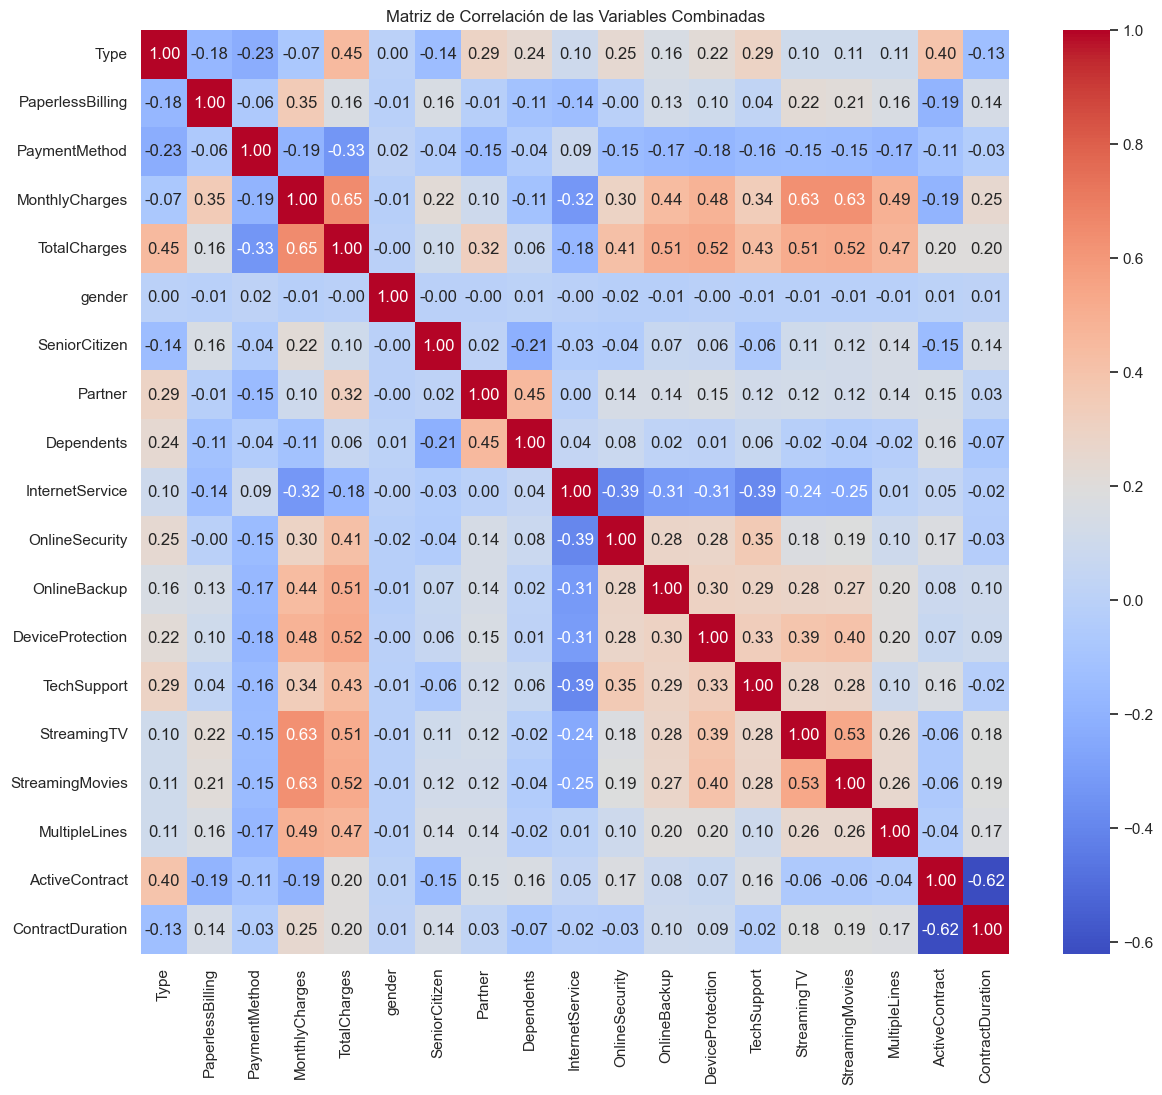

In [29]:
plt.figure(figsize=(14, 12))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Matriz de Correlación de las Variables Combinadas')
plt.show()

Observamos cómo se relacionan las variables; el área donde hay más calor es en las relacionadas con los servicios extras y los cargos mensuales y totales, lo que se traduce a más servicios, más pagas. También podemos ver una correlación importante entre los servicios de streaming de TV o películas, podemos entender que si el cliente contrata uno es probable que contrate el otro, así podemos introducir estrategias de marketing.

Podemos ver también la correlación negativa con mayor impacto, que es entre el servicio de internet y el soporte técnico. Esto podría indicar que clientes con ciertos tipos de servicios de internet tienden a no contratar el soporte técnico; puede ser que un servicio sea de mayor calidad que el otro (fibra óptica).

Hay caracteristicas con baja correlacion con el resto, otras que tienen una alta correlacion entre ellas (negativa o positiva). Estas podrian no ser importantes para entrenar el modelo. Estos resultados son importantes para el desarrollo posterior.

##### Análisis de Contingencia

Teniendo una mejor idea de las correlaciones entre las características, podemos realizar análisis de contingencia utilizando el estadístico chi cuadrado entre dos variables de interés. Lo haremos con los cargos mensuales y el servicio extra de TV.

In [30]:
# Función para calcular el estadístico Chi-cuadrado entre dos variables categóricas
def chi2_test_of_independence(df, col1, col2):
    contingency_table = pd.crosstab(df[col1], df[col2])
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    return chi2, p

chi2, p = chi2_test_of_independence(merged_df, 'MonthlyCharges', 'StreamingTV')
print(f'Chi-cuadrado: {chi2}, p-valor: {p}')

Chi-cuadrado: 4139.134070744171, p-valor: 3.084600533235019e-227


### Análisis de Tendencias Temporales

Realizemos una analisis temporar de los datos, especificamente en el dataframe. Comenzamos por visualizar la duracion de los contratos.

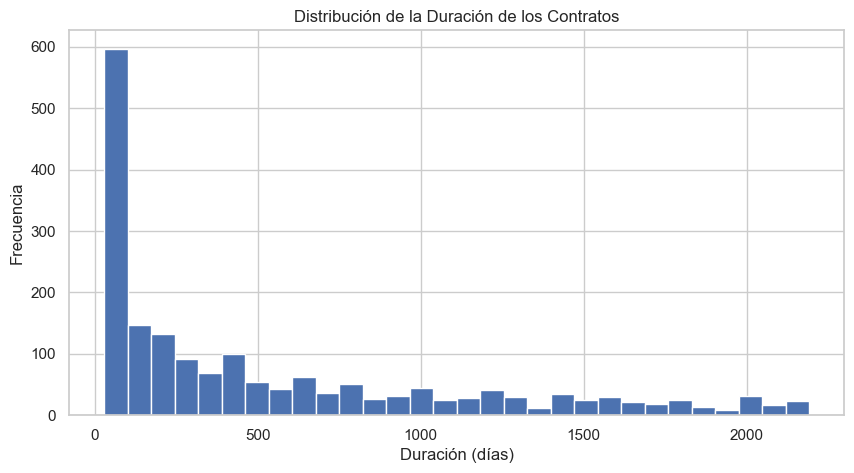

In [31]:
contract_df['ContractDuration'] = contract_df['ContractDuration'] = (contract_df['EndDate'] - contract_df['BeginDate']).dt.days

plt.figure(figsize=(10, 5))
contract_df['ContractDuration'].hist(bins=30)
plt.title('Distribución de la Duración de los Contratos')
plt.xlabel('Duración (días)')
plt.ylabel('Frecuencia')
plt.show()


La duración de los contratos indica que aproximadamente el 75 % de los clientes nuevos no pasan los 100 días.

Calcularemos la tasa de cancelación por mes

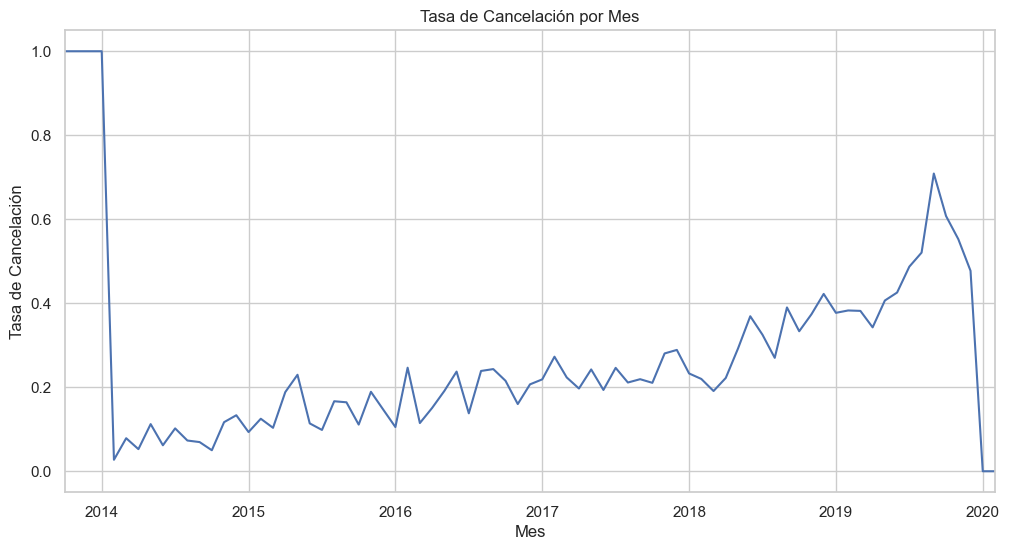

In [32]:
contract_df['Cancelled'] = contract_df['EndDate'].notna().astype(int)
contract_df['Month'] = contract_df['BeginDate'].dt.to_period('M')
cancellations_per_month = contract_df.groupby('Month')['Cancelled'].mean()

plt.figure(figsize=(12, 6))
cancellations_per_month.plot()
plt.title('Tasa de Cancelación por Mes')
plt.xlabel('Mes')
plt.ylabel('Tasa de Cancelación')
plt.show()


La tasa de cancelación por mes va en tendencia, aumentando cada año.

Crearemos una serie temporal del numero de contratos por mes.

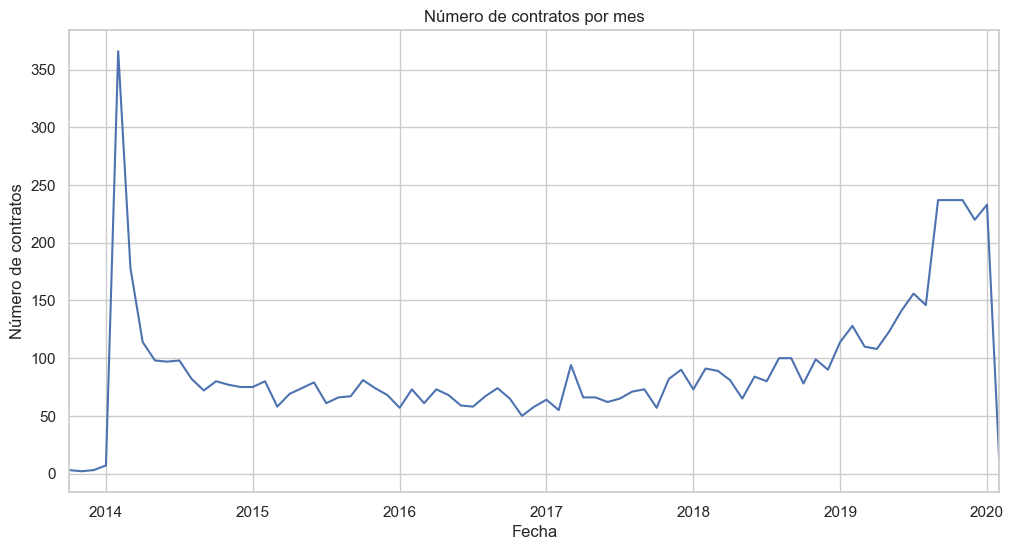

In [33]:
contracts_per_month = contract_df.groupby(contract_df['BeginDate'].dt.to_period('M')).size()

contracts_per_month.plot(figsize=(12, 6), title='Número de contratos por mes')
plt.xlabel('Fecha')
plt.ylabel('Número de contratos')
plt.show()

El número de contratos por mes se ha mantenido en el pasado, pero en los últimos años va en aumento.